# Amazon Prime Video Playback Analyzer (APVanalyzer)
### Marco Iorio
#### PhD in Computer and Control Engineering, XXXIV cycle, Politecnico di Torino
#### Python In The Lab (Spring edition)

**Abstract** This python script provides a simple way to analyze the network traces referred to the playback of a movie and/or TV show from Amazon Prime Video. In particular, it plots multiple graphs showing the most relevant information to study how the player reacts to different network conditions.

### Introduction
Prime Video is a video on demand service that is developed, owned, and operated by Amazon. The goal of this script is to analyze and understand how the video streaming quality is automatically adapted by the video player (i.e. at the client side) when the network conditions change (e.g. the available bandwidth is increased or reduced), to guarantee a flawless playback experience. In particular, the experiment has been carried out by playing the selected video using a normal browser and recording the HTTP requests performed by the browser itself and the corresponding responses from the server. The output of the capture, as provided by the browser, is an HAR (HTTP Archive format) file, a JSON-formatted archive file containing the log of the interactions between the client and the server. To compare the reaction exhibited by the video player to different network conditions, the experiment has been repeated multiple times using a traffic shaper (`wondershaper`) to simulate different available download bandwidths. Finally, the `python` script parses the information contained in the HAR file and performs the computations necessary to plot multiple graphs representing, for instance, the download throughput, the selected playback bitrate and the estimated amount of locally buffered data. The following presents the main functionalities provided by the python script. In alternative, it can also be executed directly (`python3 AmazonPrimeVideoAnalyzer.py --help` for a minimal help).

### Setup the environment

In [1]:
import os, sys
import matplotlib.pyplot as plt
import APVanalyzer as apva

base_dir = "./SampleCaptures"

capture_show_name = "the-man-in-the-high-castle"

# Available captures characterized by different shaper configurations:
# - full: no traffic shaping
# - 2048: fixed traffic shaping at 2Mbps
# - 8192: fixed traffic shaping at 8Mbps
# - shaper1: increasing step traffic shaping
# - shaper2: random step traffic shaping
# - on-off: traffic shaping alternating on (i.e. download) and off (i.e. no download) periods.
capture_shaper_config = "shaper1"

# The filename is constructed as "show_name"-"shaper_config".*
selected_capture = "{}-{}".format(capture_show_name, capture_shaper_config)

### Load the shaper CSV file
In this step, the log of how the traffic shaper has been configured is loaded by the `ShaperCSVParser` object. The log is expected to stored in a CSV file, composed of tuples (initial timestamp in Unix format, configured bandwidth limit in bps)

In [2]:
shaper_csv_file = "{}.csv".format(selected_capture)
shaper_csv_parser = apva.ShaperCSVParser(base_dir, shaper_csv_file)

Shaper file correctly read: 10 configurations

### Parse the content of the HAR file
In this step, the core parsing and computations are performed. Initially, the content of the HAR file is loaded in memory, the relevant pieces of information are extracted and all the requested computations performed (e.g. to compute the download throughput and the playback bitrate for each second). Besides the location of the HAR file, two additional parameters can be supplied to the constructor:
1. A `MPDParser` object: it represents the content of a MPD (Media Presentation Description) file, a file describing the chunks the streamed video is divided in and the available representations (i.e. different qualities) offered by the server. In case it is locally available, the object can be initialized and passed as parameter to the `HARAnalyzer` constructor. If the parameter is set to `None`, instead, the constructor takes care of downloading the file (from the url extracted by the HAR file) and initializing the corresponding object. In case of success, a message displays where the MPD file has been saved.
2. A `ShaperCSVParser` object: it represents how the traffic shaper has been configured (can be `None` if no shaping was performed).

In [3]:
har_file = "{}.har".format(selected_capture)
har_analyzer = None

try:
    har_analyzer = apva.HARAnalyzer(base_dir, har_file, None, shaper_csv_parser)
except apva.APVanalyzerException as ex:
    sys.stderr.write("Failed to construct the har_analyzer object: {}\n".format(ex))

Trying to download MPD file from 'https://s3-dub-ww.cf.dash.row.aiv-cdn.net/dm/2$uJ27cOaWQZO6DuN_WrKqXg0FlXk~/b3ce/4ea5/7b29/4bac-b2eb-3c727a156d28/e615d03c-a0fa-42b8-99e5-f10048a8b667_corrected.mpd?encoding=hex'...
MPD file correctly downloaded and saved as './SampleCaptures/the-man-in-the-high-castle-shaper1.mpd'


### Manually create the MPDParser object (in case of error)
If the `HARAnalyzer` object fails to download the MPD file (e.g. since you are offline or the link is no longer valid), it is possible to manually create the `MPDParser` instance from a locally available file.

In [4]:
if har_analyzer is None:
    mpd_file = "{}.mpd".format(capture_show_name)
    mpd_parser = apva.MPDParser(base_dir, mpd_file)
    har_analyzer =  apva.HARAnalyzer(base_dir, har_file, mpd_parser, shaper_csv_parser)

### Plot the different available bitrates
In this step, the generated `MPDParser` object is used to plot the different representations offered by the server for the selected TV show.
In this specific case, the server offers 15 different representations: each subplot plots one of them, showing the actual bitrate for the whole duration, the average and the nominal bitrates.

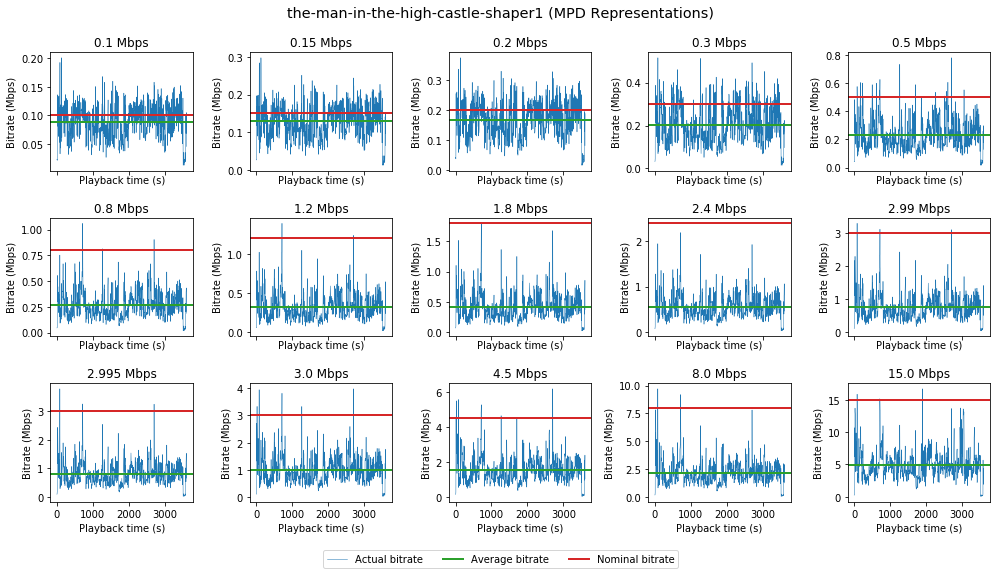

In [5]:
mpd_parser = har_analyzer.mpd_parser
mpd_parser.plot_representation_bitrate_plots(figsize=(14,8))

# Customize the appearence in terms of spacing of the subplots
plt.subplots_adjust(bottom=0.12, top=0.9, wspace=0.40, hspace=0.40)

### Plot the graph in download timescale
In this step, the `HARAnalyzer` object is used to plot the graphs showing all the most important information in *download timescale* (i.e. the `x` axis runs from the beginning to the end of the streaming period in clock time). The function produces three different subplots:
1. *Throughput and Bitrate*: summarizes for each second the download throughput, the requested video bitrate (i.e. the one  from the HTTP request), the playback bitrate (i.e. the one currently played) and the traffic shaper configuration.
2. *Buffer size*: provides an estimation of the amount of video currently stored in the local buffer (in seconds); three reference lines are plotted as 0, 1 and 2 minutes, being significant points where the behavior of the player changes.
3. *On/Off*: represents in a compact form the time periods characterized by network activity (i.e. video download) and inactivity.

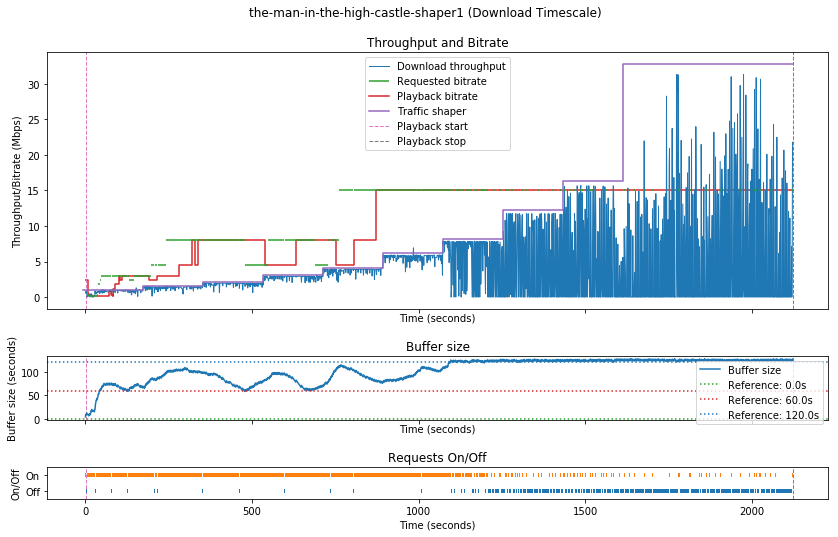

In [6]:
har_analyzer.plot_download_timescale_graph(figsize=(14,8))

# Customize the appearance in terms of spacing of the subplots
plt.subplots_adjust(top=0.90, hspace=0.40)

### Plot the graph in playback timescale
In this step, the `HARAnalyzer` object is used to plot the graph showing all the most important information in *playback timescale* (i.e. the `x` axis runs from the beginning to the end of the video time, thus it stops in case of video freezing). In particular, the graph summarizes for each playback second the associated nominal bitrate (i.e. the one contained in the HTTP requests) and the actual one (computed from the amount of bytes downloaded to playback that specific video second). The nominal bitrate is not constant since the player requests different representations depending on the current network conditions (and the amount of buffered video still available) to guarantee a flawless playback. 

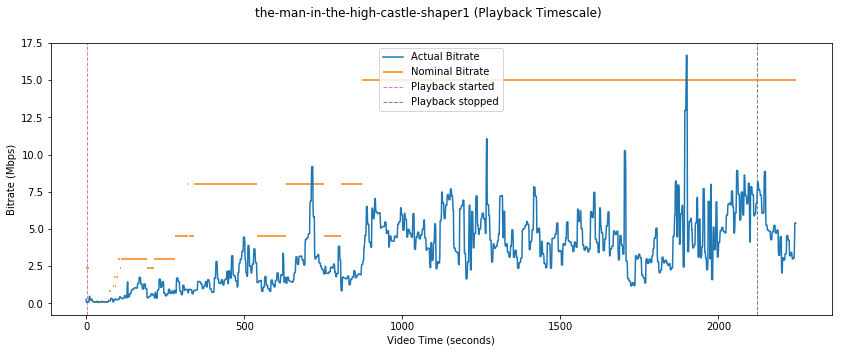

In [7]:
har_analyzer.plot_playback_timescale_graph(figsize=(14,5))

### Conclusions
Concluding, this Jupyter Notebook exemplifies the main functionalities provided by the `APVanalyzer` python module. In particular, the module provides a simple way to parse and analyze HAR capture files referred to an Amazon Prime Video playback, showing multiple graphs to compare the player behavior when the network conditions vary. Hence, it makes possible to grasp the logic exploited by the player to change the video quality requested to guarantee a flawless playback experience and maintain the amount of buffered data above a minimum threshold.

<sub>Disclaimer: the author is not associated in any way with Amazon and this python script has been developed for research purposes only. The script is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. In particular, no warranty is provided that the script will continue to work in case Amazon Prime Video modifies the adopted request/response format.</sub>